In [ ]:
!pip3 install selenium
!pip3 install webdriver-manager
!pip3 install requests
!pip3 install matplotlib
!pip3 install numpy
!pip3 install pandas

In [3]:
# Import libraries
import calendar
import time
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.common.by import By

In [ ]:
# Define base url
base_url = "https://www.cazoo.co.uk"

In [ ]:
# Create Pandas Dataframe
vehicle_df = pd.DataFrame(columns=['Make', 'Model', 'Price (£)', 'Milage', 'Registration Year', 'Registration Month', 'Gearbox', 'Fuel Type', 'N of Owners'])

In [ ]:
# Get response code
response = requests.get(base_url)
print("Response code: ", response.status_code)

In [ ]:
# Create page counter
page_no = 1

In [ ]:
# Loop for pages
for page in range(155):

    # Define url
    page_no = page
    listings_url = f"https://www.cazoo.co.uk/cars/?page={page_no}"

    # Get page url and parse it
    response = requests.get(listings_url)
    soup = BeautifulSoup(response.text, features="html.parser")
    
    # Find listings
    listings = soup.find_all(class_='vehicle-cardstyles__InfoWrap-sc-1bxv5iu-2 laxUtI')

    # Listing counter
    listing_count = 1

    # Print status
    print(f"Scraping from page {page_no}...")

    # Get a tags (urls) for each listing
    for listing in listings:

        # Print listing number
        print(f"listing {listing_count}...")

        # Find 'a' tags containing the URLs to each listing
        a_tags = listing.find_all('a')

        # In each url scrape the data
        for car_url in a_tags:

            # Parse html
            response = requests.get(base_url + car_url['href'])
            soup = BeautifulSoup(response.content, features='html.parser')

            # Get make and model
            try:
                make_model = soup.find('h1', class_='sc-yrk414-0 Abyeg').text.strip()
                make, model = make_model.split(' ', 1)
            except:
                make, model = "n/a"

            # Get price
            try:
                driver = webdriver.Chrome()
                driver.get(base_url + car_url['href'])
                time.sleep(1)
                price = driver.find_element(By.CSS_SELECTOR, "div.md\:px-l:nth-child(3) > p:nth-child(1) > small:nth-child(1) > small:nth-child(2) > strong:nth-child(1)").text
                price = int(price[1:].replace(',', ''))
            except:
                price = "n/a"

            # Get mileage
            try:
                mileage = int(soup.find_all('li', class_="sc-1qzxxja-0 sc-17oqk9n-0 cMysQa etVBLA")[0].text.strip().replace(' miles','').replace(',',''))
            except:
                mileage = "n/a"

            # Get registration year
            try:
                reg_year = soup.find_all('li', class_="sc-1qzxxja-0 sc-17oqk9n-0 cMysQa etVBLA")[1].text.strip()
                reg_year = int(reg_year[-4:])
            except:
                reg_year = "n/a"

            # Get registration month
            try:
                reg_month = soup.find_all('li', class_="sc-1qzxxja-0 sc-17oqk9n-0 cMysQa etVBLA")[1].text.strip()
                reg_month = reg_month[:3]
                reg_month = int(list(calendar.month_abbr).index(reg_month))
            except:
                reg_month = "n/a"

            # Get gearbox
            try:
                gearbox = soup.find_all('li', class_="sc-1qzxxja-0 sc-17oqk9n-0 cMysQa etVBLA")[2].text.strip()
            except:
                gearbox = "n/a"

            # Get fuel type
            try:
                fuel_type = soup.find_all('li', class_="sc-1qzxxja-0 sc-17oqk9n-0 cMysQa etVBLA")[3].text.strip()
            except:
                fuel_type = "n/a"

            # Get number of owners
            try:
                number_of_owners = soup.select("dl.divide-y:nth-child(2) > div:nth-child(3) > dd:nth-child(2)")[0]
                number_of_owners = int(number_of_owners.text)
            except:
                number_of_owners = "n/a"

            # Create row
            row = pd.Series({'Make': make,
                             'Model': model,
                             'Price (£)': price,
                             'Milage': mileage,
                             'Registration Year': reg_year,
                             'Registration Month': reg_month,
                             'Gearbox': gearbox,
                             'Fuel Type': fuel_type,
                             'N of Owners': number_of_owners
                            })

            # Add row to pandas data frame
            vehicle_df.loc[len(vehicle_df)] = row
        
        # There are 47 listings per page. Break inner loop when 47 is reached
        listing_count += 1
        if listing_count > 47:
            break

    # Go to next page
    page_no += 1

In [ ]:
# Save to csv
vehicle_df.to_csv("cazoo_used_cars_dataset.csv")

In [22]:
# Read dataset
vehicle_df = pd.read_csv("cazoo_used_cars_dataset.csv")
vehicle_df

,Unnamed: 0,Make,Model,Price (£),Milage,Registration Year,Registration Month,Gearbox,Fuel Type,N of Owners
0,0,Ford,Ka,6350.0,56530.0,2016.0,4.0,Manual,Petrol,3.0
1,1,Citroen,C4,6750.0,50727.0,2015.0,9.0,Manual,Petrol,1.0
2,2,Suzuki,Celerio,6800.0,23190.0,2017.0,3.0,Manual,Petrol,3.0
3,3,Dacia,Sandero,NaN,10837.0,2016.0,5.0,Manual,Petrol,1.0
4,4,Suzuki,Celerio,7000.0,23778.0,2016.0,3.0,Manual,Petrol,1.0
...,...,...,...,...,...,...,...,...,...,...
5587,5587,Mini,Hatch,22200.0,17998.0,2019.0,8.0,Automatic,Petrol,1.0
5588,5588,BMW,X3,22250.0,57467.0,2017.0,9.0,Automatic,Diesel,3.0
5589,5589,MG,MG ZS,22250.0,22096.0,2020.0,10.0,Automatic,Electric,NaN
5590,5590,Toyota,C-HR,22250.0,9564.0,2019.0,3.0,Automatic,Hybrid,NaN


In [23]:
# Drop rows with 'n/a' & convert to integers
vehicle_df.dropna(inplace=True)
vehicle_df.drop(columns=["Unnamed: 0"], inplace=True)
columns_to_integers = ['Milage', 'Registration Year', 'Registration Month', 'N of Owners']
vehicle_df[columns_to_integers] = vehicle_df[columns_to_integers].astype(int)
vehicle_df

,Make,Model,Price (£),Milage,Registration Year,Registration Month,Gearbox,Fuel Type,N of Owners
0,Ford,Ka,6350.0,56530,2016,4,Manual,Petrol,3
1,Citroen,C4,6750.0,50727,2015,9,Manual,Petrol,1
2,Suzuki,Celerio,6800.0,23190,2017,3,Manual,Petrol,3
4,Suzuki,Celerio,7000.0,23778,2016,3,Manual,Petrol,1
5,Fiat,500,7000.0,41216,2015,9,Manual,Petrol,3
...,...,...,...,...,...,...,...,...,...
5585,BMW,X2,22200.0,33204,2018,9,Automatic,Diesel,3
5586,Jeep,Compass,22200.0,12550,2019,5,Automatic,Petrol,3
5587,Mini,Hatch,22200.0,17998,2019,8,Automatic,Petrol,1
5588,BMW,X3,22250.0,57467,2017,9,Automatic,Diesel,3


In [24]:
# Data Frame information
vehicle_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5044 entries, 0 to 5591
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Make                5044 non-null   object 
 1   Model               5044 non-null   object 
 2   Price (£)           5044 non-null   float64
 3   Milage              5044 non-null   int64  
 4   Registration Year   5044 non-null   int64  
 5   Registration Month  5044 non-null   int64  
 6   Gearbox             5044 non-null   object 
 7   Fuel Type           5044 non-null   object 
 8   N of Owners         5044 non-null   int64  
dtypes: float64(1), int64(4), object(4)
memory usage: 394.1+ KB


In [25]:
# Data Frame overview
vehicle_df.describe()

,Price (£),Milage,Registration Year,Registration Month,N of Owners
count,5044.000000,5044.000000,5044.000000,5044.000000,5044.000000
mean,15306.701031,28780.654044,2018.340008,6.564631,1.697264
std,3565.646188,16693.041952,1.460423,3.308272,0.873375
min,6350.000000,2.000000,2014.000000,1.000000,1.000000
25%,12550.000000,16070.750000,2017.000000,3.000000,1.000000
50%,15150.000000,26315.500000,2019.000000,6.000000,1.000000
75%,18000.000000,38944.750000,2019.000000,9.000000,2.000000
max,22250.000000,98705.000000,2022.000000,12.000000,8.000000


In [26]:
# Stock by registration year 
registration_year_count = vehicle_df['Registration Year'].value_counts().sort_index(ascending=False)
registration_year_count

2022     102
2021     225
2020     516
2019    1688
2018    1206
2017     661
2016     516
2015     125
2014       5
Name: Registration Year, dtype: int64

In [27]:
# Top 10 makes in stock by average price
brand_averages = vehicle_df.groupby('Make')['Price (£)'].mean()
top_10_brands_by_average_price = brand_averages.sort_values(ascending=False).head(10)
top_10_brands_by_average_price = round(top_10_brands_by_average_price, 2)
top_10_brands_by_average_price

Make
Lexus            21700.00
Land             19915.52
Mercedes-Benz    19349.81
Jaguar           18578.57
BMW              18448.17
Audi             18185.02
Alfa             18050.00
Subaru           17925.00
Volvo            17438.04
Mitsubishi       16784.21
Name: Price (£), dtype: float64

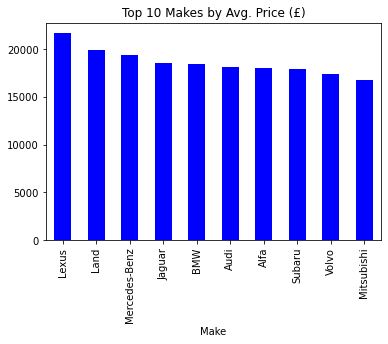

In [28]:
# Bar chart top 10 makes in stock
barchart = top_10_brands_by_average_price.plot.bar(x="Brands", y="Price (£)", cmap="winter", title="Top 10 Makes by Avg. Price (£)")

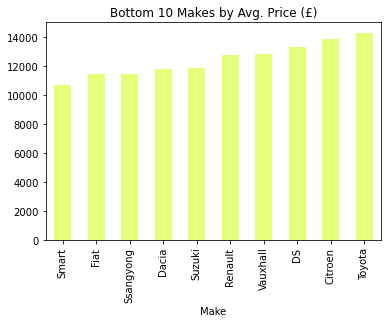

In [29]:
# Bottom 10 makes in stock by average price
bottom_10_brands_by_average_price = brand_averages.sort_values(ascending=True).head(10)

# Bar chart bottom 10 makes in stock
barchart = bottom_10_brands_by_average_price.plot.bar(x="Make", y="Average Price (£)", cmap="Wistia", title="Bottom 10 Makes by Avg. Price (£)")

In [30]:
# Top 10 models in stock by average price
model_averages = vehicle_df.groupby('Model')['Price (£)'].mean()
top_10_models_by_average_price = model_averages.sort_values(ascending=False).head(10)
top_10_models_by_average_price

Model
Prius+                 22000.0
F-PACE                 21950.0
NX 300h                21700.0
A5 Cabriolet           21700.0
Kodiaq                 21650.0
GLC Class              21500.0
CX-30                  21400.0
Arteon                 21360.0
XC40                   21250.0
2 Series Gran Coupe    21200.0
Name: Price (£), dtype: float64

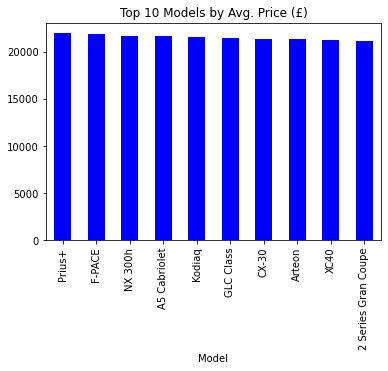

In [31]:
# Bar chart top 10 models in stock
barchart = top_10_models_by_average_price.plot.bar(x="Models", y="Price (£)", cmap="winter", title="Top 10 Models by Avg. Price (£)")

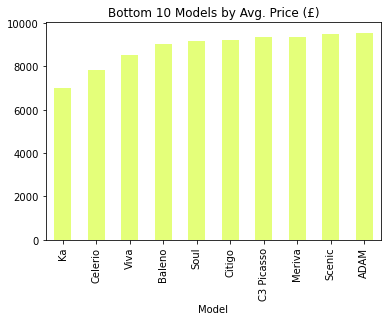

In [32]:
# Bottom 10 models in stock by average price
bottom_10_models_by_average_price = model_averages.sort_values(ascending=True).head(10)

# Bar chart bottom 10 makes in stock
barchart = bottom_10_models_by_average_price.plot.bar(x="Make", y="Average Price (£)", cmap="Wistia", title="Bottom 10 Models by Avg. Price (£)")

In [33]:
# Relationship between registration year and resale price
year_averages = vehicle_df.groupby('Registration Year')['Price (£)'].mean().sort_index(ascending=False)
year_averages_df = round(pd.DataFrame(year_averages),2)
year_averages_df

,Price (£)
Registration Year,
2022,17802.45
2021,16386.00
2020,15835.37
2019,15818.19
2018,15367.45
2017,14739.33
2016,13331.30
2015,12983.60
2014,10880.00


Text(0, 0.5, 'Avg Price (£)')

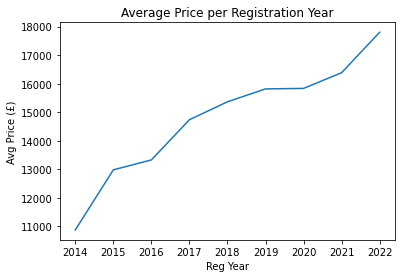

In [34]:
# Line graph - Registration year vs price
registration_years = year_averages_df.index.tolist()
prices_per_year = year_averages_df.iloc[:,0].tolist()

plt.plot(registration_years, prices_per_year, label="Price (£)")
plt.title("Average Price per Registration Year")
plt.xlabel("Reg Year")
plt.ylabel("Avg Price (£)")

([<matplotlib.patches.Wedge at 0x7f3bfad12400>,
 [Text(-0.1734161160785025, 1.0862443788965022, 'Alternative'),
  Text(-0.9616901984400528, 0.5339962192977888, 'Diesel'),
  Text(0.9515451367432781, -0.5518712284040694, 'Petrol')],
 [Text(-0.09459060877009226, 0.5924969339435465, '0.6%'),
  Text(-0.5245582900582105, 0.29127066507152116, '28.2%'),
  Text(0.519024620041788, -0.3010206700385833, '71.2%')])

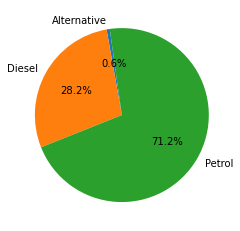

In [38]:
# Get number of cars in stock for each fuel type
fuel_count = vehicle_df['Fuel Type'].value_counts()

# Group alternative fuels (to avoid overlapping in pie chart as value are too small)
fuel_types = list(fuel_count.index)
fuel_type_count = []

for fuel_type in fuel_types:
    fuel_type_count.append(fuel_count[fuel_type])

fuel_type_dict_count = {'Fuel Type': fuel_types, 'Count': fuel_type_count}
fuel_type_dict_count

fuel_type_df = pd.DataFrame(fuel_type_dict_count)

fuel_type_df['Fuel Type'] = fuel_type_df['Fuel Type'].replace(['Hybrid', 'Petrol & LPG', 'Electric', 'Plug-in hybrid'], 'Alternative')
fuel_type_df = fuel_type_df.groupby('Fuel Type').sum()

# Fuel type pie chart
fuel_type_count = fuel_type_df['Count']
plt.pie(fuel_type_count, labels=fuel_type_count.index, autopct='%1.1f%%', startangle=98)

<AxesSubplot:title={'center':'Fuel Type by Avg. Price (£)'}, xlabel='Fuel Type'>

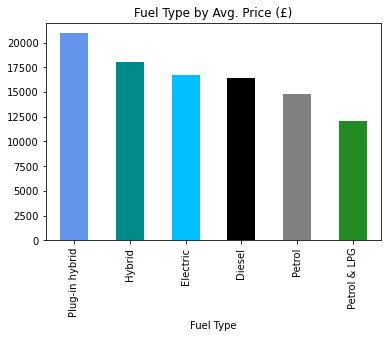

In [39]:
# Average price by fuel type
fuel_type_average = vehicle_df.groupby('Fuel Type')['Price (£)'].mean().sort_values(ascending=False)
fuel_type_average = round(fuel_type_average, 2)
fuel_type_average.index
colours = {'Hybrid': 'darkcyan', 'Diesel':'black', 'Petrol':'grey', 'Petrol & LPG':'forestgreen', 'Electric':'deepskyblue', 'Plug-in hybrid': 'cornflowerblue'}
fuel_type_average.plot.bar(x="Fuel Type", y="Price", color=[colours[key] for key in fuel_type_average.index], title="Fuel Type by Avg. Price (£)")